In [1]:
import serial
import numpy as np
from math import log
from math import sqrt
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm
import scipy.io as sio
from sklearn.linear_model import LinearRegression
import csv

In [2]:
def write_and_read(ser, cmd):
    to_write = cmd+"\n"
    ser.write(to_write.encode())
    res = ser.readline().decode().rstrip('\r\n')
    print('({}): OK ({})'.format(to_write.rstrip('\n'), res) )
    return res

In [3]:
def flush_serial(ser):
    while True:
        line = ser.readline().decode().rstrip('\r\n')
        if line == "":
            break
        else:
            print(line)

RANGE_5V_UNI        =  "5V_UNI"
RANGE_10V_UNI       =  "10V_UNI"
RANGE_5V_BIP        =  "5V_BIP"
RANGE_10V_BIP       =  "10V_BIP"
RANGE_20mA_UNI      =  "20mA_UNI"
RANGE_24mA_UNI      =  "24mA_UNI"
RANGE_4_24mA        =  "4_24mA"
RANGE_20mA_BIP      =  "20mA_BIP"
RANGE_24mA_BIP      =  "24mA_BIP"
RANGE_22mA_OVR      =  "22mA_OVR"

def config_channel_mode(ser, slot, ch, md):
    cmd = "{}:{}:CONF:".format(slot,ch)+md
    write_and_read(ser, cmd)
    # print(cmd)

def set_current(ser, slot, ch, value, md):
    if md==RANGE_20mA_UNI or md==RANGE_24mA_UNI or md==RANGE_4_24mA or md==RANGE_20mA_BIP or md==RANGE_24mA_BIP or md==RANGE_22mA_OVR:
        dacCode = convert_dac_code(value, md)
        if dacCode>=0:
            cmd = "{}:{}:CURR:{}".format(slot, ch, dacCode)
            write_and_read(ser, cmd)
        else:
            print("Error: Value out of range!")
    else:
        print("Mode error: Channel {} is not in current mode".format(ch))

def set_voltage(ser, slot, ch, value, md):
    if md==RANGE_5V_UNI or md==RANGE_10V_UNI or md==RANGE_5V_BIP or md==RANGE_10V_BIP:
        dacCode = convert_dac_code(value, md)
        if dacCode>=0:
            cmd = "{}:{}:VOLT:{}".format(slot, ch, dacCode)
            write_and_read(ser, cmd)
        else:
            print("Error: Value out of range!")
    else:
        print("Mode error: Channel {} in Slot {} is not in voltage mode".format(ch, slot))

AD5753_REFIN           = "AD_REFIN"
AD5753_REFGND          = "AD_REFGND"
AD5753_ISENSE          = "AD_CURR"
AD5753_LOADP           = "AD_VLOAD"
MAX11254_CURRENT       = "MAX_CURR"
MAX11254_SENSE_VOLTAGE = "MAX_VSENSE"
MAX11254_LOAD_VOLTAGE  = "MAX_VLOAD"

def measure(ser, slot, ch, md):
    cmd = "{}:{}:MEAS:".format(slot,ch)+md
    adc_code = int(write_and_read(ser, cmd))
    res = convert_adc_code(adc_code, md)
    return res

INTERNAL_LOAD = "INTERNAL"
EXTERNAL_LOAD = "EXTERNAL"

def toggle_output_switch(ser, slot, ch, value):
    cmd = "{}:{}:REFR:{}".format(slot, ch, value)
    write_and_read(ser, cmd)
    return

def reset(ser):
    cmd = "*RST"
    write_and_read(ser, cmd)
    flush_serial(ser)
    sleep(1)
    
def convert_dac_code(value, md):
    if md == RANGE_5V_UNI and value >= 0 and value <= 5:
        return int(value*65535/5)
    elif md == RANGE_10V_UNI and value >= 0 and value <= 10:
        return int(value*65535/10)
    elif md == RANGE_5V_BIP and value >= -5 and value <= 5:
        return int(value*32767/5)+32768
    elif md == RANGE_10V_BIP and value >= -10 and value <= 10:
        return int(value*32765/10)+32768
    elif md == RANGE_20mA_UNI and value >= 0 and value <= 20:
        return int(value*65535/20)
    elif md == RANGE_24mA_UNI and value >= 0 and value <= 24:
        return int(value*65535/24)
    elif md == RANGE_4_24mA_UNI and value >= 4 and value <= 24:
        return int((value-4)*65535/20)
    elif md == RANGE_20mA_BIP and value >= -20 and value <= 20:
        return int(value*32767/20)+32768
    elif md == RANGE_24mA_BIP and value >= -24 and value <= 24:
        return int((value+1)*65535/23)+32768
    else:
        return -1

def convert_adc_code(value, md):
    if md == AD5753_REFIN:
        return value/4096*2.75
    elif md == AD5753_REFGND:
        return value/4096*2.5
    elif md == AD5753_ISENSE:
        return value/4096*2.5
    elif md == AD5753_LOADP:
        return 30*value/4096-15
    elif md == MAX11254_CURRENT:
        return (value/8388608-1)*25
    elif md == MAX11254_SENSE_VOLTAGE:
        return (value/8388608-1)*25
    elif md == MAX11254_LOAD_VOLTAGE:
        return (value/8388608-1)*25
    else:
        return -1

def set_calibration_params(ser, slot, ch, gain_i, offset_i, gain_v, offset_v):
    cmd = "{}:{}:CALS:{},{},{},{},".format(slot, ch, gain_i, offset_i, gain_v, offset_v)
    # print(cmd)
    write_and_read(ser, cmd)

def reset_calibration(ser):
    cmd = "*CALC"
    write_and_read(ser, cmd)

def get_occupancy(ser):
    cmd = "*OCC?"
    write_and_read(ser, cmd)
    occupancy = []
    for slot in range(16):
        occupancy.append(int(ser.readline().decode().rstrip('\r\n'),2))
        if (occupancy[slot]>0):
            print("Slot {}:".format(slot), end=" ")
            for ch in range(8):
                if ( occupancy[slot]&(1<<ch) ):
                    print("Ch {}: good,".format(ch), end=" ")
                else:
                    print("Ch {}: bad,".format(ch), end=" ")
            print("")
        else:
            print("Slot {} is not used".format(slot))
    occupancy = np.asarray(occupancy)
    return occupancy

In [4]:
def save_csv(data, filename):
    with open(filename, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',')
        nRep = int((data.shape[1]-1)/3)
        firstLine = ['dac_code']
        for idx in range(nRep):
            firstLine.append('iSense')
            firstLine.append('VSense')
            firstLine.append('VLoad')
        csv_writer.writerow(firstLine)
        csv_writer.writerows(data)

def read_csv(filename):
    data = []
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        isFirstLine = True
        for row in reader:
            if not isFirstLine:
                data.append([int(i) for i in row])
            isFirstLine = False
        data = np.asarray(data)
    return data

In [5]:
def evalute(x,data,std):
    x = x.reshape((-1,1))
    reg = LinearRegression().fit(x, data)
    R2 = reg.score(x,data)
    residual = data-reg.predict(x)
    inl = max(abs(residual))/(max(data)/65536)
    MSE = np.square(residual).mean()
    res = log(MSE/max(data),2)
    return R2, res, inl, residual

In [6]:
# example of using "*OCC" command
with serial.Serial('COM3', 500000, timeout=2) as ser: 
    flush_serial(ser) #flush serial port
    occupancy = get_occupancy(ser)

(*OCC?): OK (Occupancy:)
Slot 0 is not used
Slot 1 is not used
Slot 2 is not used
Slot 3 is not used
Slot 4 is not used
Slot 5 is not used
Slot 6 is not used
Slot 7 is not used
Slot 8: Ch 0: good, Ch 1: bad, Ch 2: good, Ch 3: good, Ch 4: good, Ch 5: good, Ch 6: good, Ch 7: bad, 
Slot 9 is not used
Slot 10 is not used
Slot 11 is not used
Slot 12 is not used
Slot 13 is not used
Slot 14 is not used
Slot 15 is not used


In [7]:
# example
with serial.Serial('COM3', 500000, timeout=2) as ser: 
    # flush_serial(ser) #flush serial port
    slot = 8
    ch = 0
    md = RANGE_10V_BIP
    config_channel_mode(ser, slot, ch, md) #config channel range
    set_voltage(ser, slot, ch, 1, md) #set voltage
    data = measure(ser, slot, ch, MAX11254_SENSE_VOLTAGE) #make a measurement
    print("result:{}".format(data))

(8:0:CONF:10V_BIP): OK (DONE)
(8:0:VOLT:36044): OK (DONE)
(8:0:MEAS:MAX_VSENSE): OK (8721509)
result:0.9921222925186157


In [8]:
# calibration
with serial.Serial('COM3', 500000, timeout=3) as ser: 
    flush_serial(ser)
    occupancy = get_occupancy(ser)
    flush_serial(ser)
    # reset_calibration(ser)
    write_and_read(ser,"*CAL")
    clear_output()
    nCal = 256
    for slot in trange(16, desc="Total"):
        for ch in trange(8, desc="Slot {}".format(slot), leave=False):
            if ( (occupancy[slot]&(1<<ch)) ):
                cal1 = []
                cal2 = []
                for index in trange(nCal, desc='Channel {}:Voltage'.format(ch), leave=False):
                    res = ser.readline().decode().rstrip('\r\n')
                    cal1.append(np.asarray(res.split(","),int))
                cal1 = np.asarray(cal1)
                for index in trange(nCal, desc='Channel {}:Current'.format(ch), leave=False):
                    res = ser.readline().decode().rstrip('\r\n')
                    cal2.append(np.asarray(res.split(","),int))
                cal2 = np.asarray(cal2)
                filename = 'calibration/Slot{}_Ch{}_cal1.csv'.format(slot,ch)
                save_csv(cal1, filename)
                filename = 'calibration/Slot{}_Ch{}_cal2.csv'.format(slot,ch)
                save_csv(cal2, filename)
    reset(ser)

KeyboardInterrupt: 

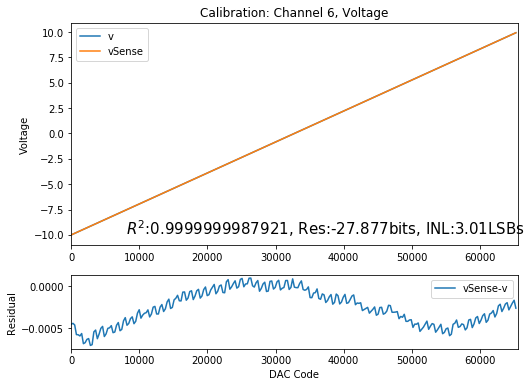

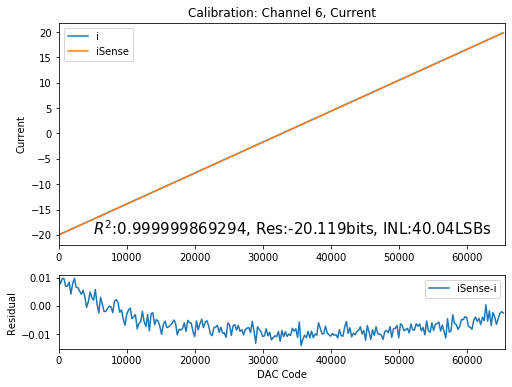

In [30]:
slot = 8
ch = 6
n = 10
filename = 'calibration/Slot{}_Ch{}_cal1.csv'.format(slot,ch)
cal1 = read_csv(filename)
x1 = cal1[:,0]
v = (x1-32768)/32768*10
length = cal1.shape[1]
vSense_avg = 0
for idx in range(2,length,3):
    vSense_avg = vSense_avg+((cal1[:,idx])/8388608-1)*25
vSense_avg = vSense_avg/n
vLoad_avg = 0
for idx in range(3,length,3):
    vLoad_avg = vLoad_avg+((cal1[:,idx])/8388608-1)*25
vLoad_avg = vLoad_avg/n

fig,axs = plt.subplots(2,1,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(x1,v,label = 'v')
axs[0].plot(x1,vSense_avg,label = 'vSense')
# axs[0].plot(x1,vLoad,label = 'vLoad')
axs[0].set_xlim(0,65536)
axs[0].set_ylabel('Voltage')
axs[0].set_title('Calibration: Channel {}, Voltage'.format(ch))
axs[0].legend()
R2, res, inl, residual_vSense = evalute(x1,vSense_avg,v)
axs[0].text(8000, -10, r'$R^2$:{:.13}, Res:{:.5}bits, INL:{:.3}LSBs'.format(R2, res, inl), fontsize=15)
# axs[1].plot(x1,vLoad-v,label='vLoad-v')
axs[1].plot(x1,vSense_avg-v,label='vSense-v')
axs[1].set_xlim(0,65536)
axs[1].set_xlabel('DAC Code')
axs[1].set_ylabel('Residual')
axs[1].legend()

filename = 'calibration/Slot{}_Ch{}_cal2.csv'.format(slot,ch)
cal2 = read_csv(filename)
x2 = cal2[:,0]
i = (x1-32768)/32768*20
iSense_avg = 0
for idx in range(1,length,3):
    iSense_avg = iSense_avg+((cal2[:,idx])/8388608-1)*2500/49.8
iSense_avg = iSense_avg/n

fig,axs = plt.subplots(2,1,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})
axs[0].plot(x2,i,label = 'i')
axs[0].plot(x2,iSense_avg,label = 'iSense')
axs[0].set_xlim(0,65536)
axs[0].set_ylabel('Current')
axs[0].set_title('Calibration: Channel {}, Current'.format(ch))
axs[0].legend()
R2, res, inl, residual_iSense = evalute(x2,iSense_avg,i)
axs[0].text(5000, -20, r'$R^2$:{:.13}, Res:{:.5}bits, INL:{:.5}LSBs'.format(R2, res, inl), fontsize=15)
axs[1].plot(x1,iSense_avg-i,label='iSense-i')
axs[1].set_xlim(0,65536)
axs[1].set_xlabel('DAC Code')
axs[1].set_ylabel('Residual')
axs[1].legend()

In [21]:
with serial.Serial('COM3', 500000, timeout=3) as ser:
    flush_serial(ser)
    slot = 8
    n = 10
    for ch in range(8):
        if ( (occupancy[slot]&(1<<ch)) ):
            print("Ch {}".format(ch))
            filename = 'calibration/Slot{}_Ch{}_cal1.csv'.format(slot,ch)
            cal1 = read_csv(filename)
            x1 = cal1[:,0]
            v = (x1-32768)*102.4+8388608
            length = cal1.shape[1]
            vSense_avg = 0
            for idx in range(2,length,3):
                vSense_avg = vSense_avg+cal1[:,idx]
            vSense_avg = vSense_avg/n
            vLoad_avg = 0
            for idx in range(3,length,3):
                vLoad_avg = vLoad_avg+cal1[:,idx]
            vLoad_avg = vLoad_avg/n

            x = vSense_avg.reshape((-1,1))
            reg = LinearRegression().fit(x, v)
            gain_v = int(reg.coef_*(1<<23))
            offset_v = int(np.mean(v-vSense_avg))+(1<<23)
            print(gain_v,offset_v)

            filename = 'calibration/Slot{}_Ch{}_cal2.csv'.format(slot,ch)
            cal2 = read_csv(filename)
            x2 = cal2[:,0]
            i = (x1-32768)*102.4*2.49/2.5+8388608
            iSense_avg = 0
            for idx in range(1,length,3):
                iSense_avg = iSense_avg+cal2[:,idx]
            iSense_avg = iSense_avg/n

            x = iSense_avg.reshape((-1,1))
            reg = LinearRegression().fit(x, i)
            gain_i = int(reg.coef_*(1<<23))
            offset_i = int(np.mean(i-iSense_avg))+(1<<23)
            print(gain_i,offset_i)

            set_calibration_params(ser, slot, ch, gain_i, offset_i, gain_v, offset_v)

Ch 0
8441939 8389041
8496483 8415283
(8:0:CALS:8496483,8415283,8441939,8389041,): OK (8496483 8415283 8441939 8389041 Done)
Ch 2
8444684 8388886
8464863 8436850
(8:2:CALS:8464863,8436850,8444684,8388886,): OK (8464863 8436850 8444684 8388886 Done)
Ch 3
8444659 8388636
8516147 8407303
(8:3:CALS:8516147,8407303,8444659,8388636,): OK (8516147 8407303 8444659 8388636 Done)
Ch 4
8446801 8388779
8435914 8402903
(8:4:CALS:8435914,8402903,8446801,8388779,): OK (8435914 8402903 8446801 8388779 Done)
Ch 5
8446150 8388655
8471544 8443255
(8:5:CALS:8471544,8443255,8446150,8388655,): OK (8471544 8443255 8446150 8388655 Done)
Ch 6
8445973 8388678
8490264 8434966
(8:6:CALS:8490264,8434966,8445973,8388678,): OK (8490264 8434966 8445973 8388678 Done)


In [18]:
# reset calibration
with serial.Serial('COM3', 500000, timeout=3) as ser:
    reset_calibration(ser)

(*CALC): OK (Done)
